Nombres : 
- Fabián Sandoval Erick José
- Sáenz de Buruaga Imanol Mendoza  
- Villalón Pineda Luis Enrique

# Objetivo

En este ejercicio, aplicarán los conocimientos adquiridos en PySpark para realizar un análisis de datos sobre un dataset. Se enfocarán en la manipulación de DataFrames, la aplicación de transformaciones, y la realización de un análisis exploratorio de datos (EDA) para extraer insights significativos.

# Dataset

tilizaremos el dataset "Titanic", que contiene información sobre los pasajeros del Titanic, incluyendo si sobrevivieron o no, su edad, clase, género, entre otros.

### Configuracion de entorno

In [1]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("TitanicAnalysis").getOrCreate()

# Cargar el dataset Titanic
df = spark.read.csv("train.csv", header=True, inferSchema=True)

### Exploracion inicial del dataset

In [3]:
# Mostrar las primeras filas
df.show(5)

# Obtener el esquema
df.printSchema()

# Contar el número de filas y columnas
print(f"Número de filas: {df.count()}")
print(f"Número de columnas: {len(df.columns)}")

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

### Limpieza de datos

In [4]:
# Verificar valores nulos
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Eliminar la columna 'Cabin'
df = df.drop('Cabin')

# Rellenar valores nulos en 'Age' con la mediana
median_age = df.approxQuantile("Age", [0.5], 0.01)[0]
df = df.na.fill(median_age, subset=["Age"])

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



### Analisis Descriptivo



In [5]:
from pyspark.sql.functions import mean, stddev, col

# Estadísticas descriptivas de 'Age'
df.select(mean("Age").alias("Mean Age"), stddev("Age").alias("Std Dev Age")).show()

# Tasa de supervivencia por género
df.groupBy("Sex").agg(mean("Survived").alias("Survival Rate")).show()

# Tasa de supervivencia por clase
df.groupBy("Pclass").agg(mean("Survived").alias("Survival Rate")).show()

+-----------------+------------------+
|         Mean Age|       Std Dev Age|
+-----------------+------------------+
|29.36158249158249|13.019696550973201|
+-----------------+------------------+

+------+-------------------+
|   Sex|      Survival Rate|
+------+-------------------+
|female| 0.7420382165605095|
|  male|0.18890814558058924|
+------+-------------------+

+------+-------------------+
|Pclass|      Survival Rate|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



### Visualizacion de datos

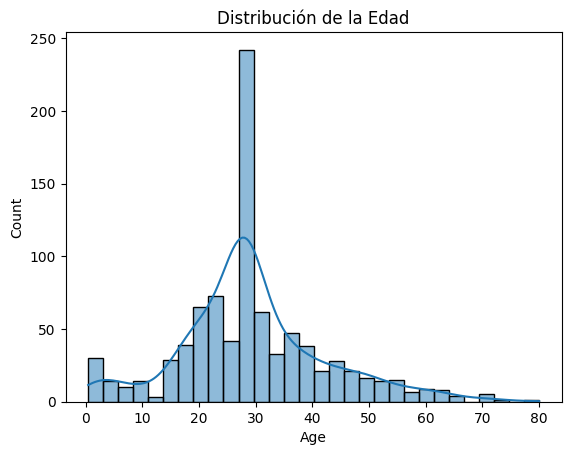

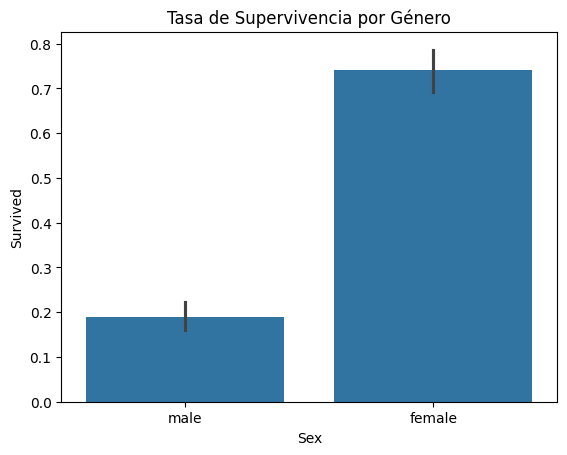

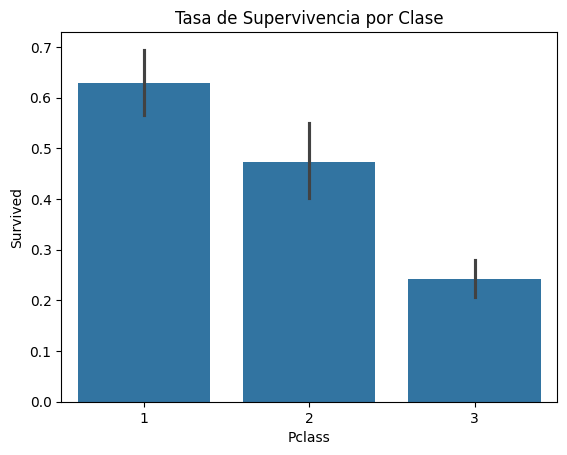

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir el DataFrame de PySpark a Pandas para visualización
pd_df = df.toPandas()

# Distribución de la edad
sns.histplot(pd_df['Age'], kde=True)
plt.title('Distribución de la Edad')
plt.show()

# Tasa de supervivencia por género
sns.barplot(x='Sex', y='Survived', data=pd_df)
plt.title('Tasa de Supervivencia por Género')
plt.show()

# Tasa de supervivencia por clase
sns.barplot(x='Pclass', y='Survived', data=pd_df)
plt.title('Tasa de Supervivencia por Clase')
plt.show()

### En esta seccion agrega dos analisis extra sobre el dataset

Tasa de supervivencia por numero de hermanos

In [22]:
survival_rate_by_sibsp = df.groupBy('SibSp').agg(mean('Survived').alias('Survival Rate')).orderBy('SibSp')
survival_rate_pd = survival_rate_by_sibsp.toPandas()
survival_rate_pd

,SibSp,Survival Rate
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


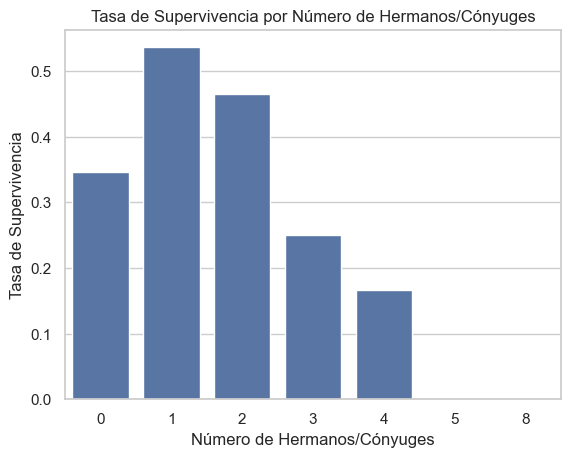

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.barplot(x='SibSp', y='Survival Rate', data=survival_rate_pd)

plt.xlabel('Número de Hermanos/Cónyuges')
plt.ylabel('Tasa de Supervivencia')
plt.title('Tasa de Supervivencia por Número de Hermanos/Cónyuges')
plt.show()

tasa de supervivencia por título

In [31]:
from pyspark.sql.functions import regexp_extract
df = df.withColumn("Title", regexp_extract(col("Name"), "([A-Za-z]+)\.", 1)) #Buscamos despues de la coma el cual nos dice el titulo 
survival_rate_by_title = df.groupBy("Title").agg(mean("Survived").alias("Survival Rate")).orderBy("Title")
survival_rate_pd = survival_rate_by_title.toPandas()
survival_rate_pd

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ENRIQUE\AppData\Local\Temp\ipykernel_16504\2350192669.py:2: SyntaxWarning: invalid escape sequence '\.'
  df = df.withColumn("Title", regexp_extract(col("Name"), "([A-Za-z]+)\.", 1)) #Buscamos despues de la coma el cual nos dice el titulo


,Title,Survival Rate
0,Capt,0.000000
1,Col,0.500000
2,Countess,1.000000
3,Don,0.000000
4,Dr,0.428571
5,Jonkheer,0.000000
6,Lady,1.000000
7,Major,0.500000
8,Master,0.575000
9,Miss,0.697802


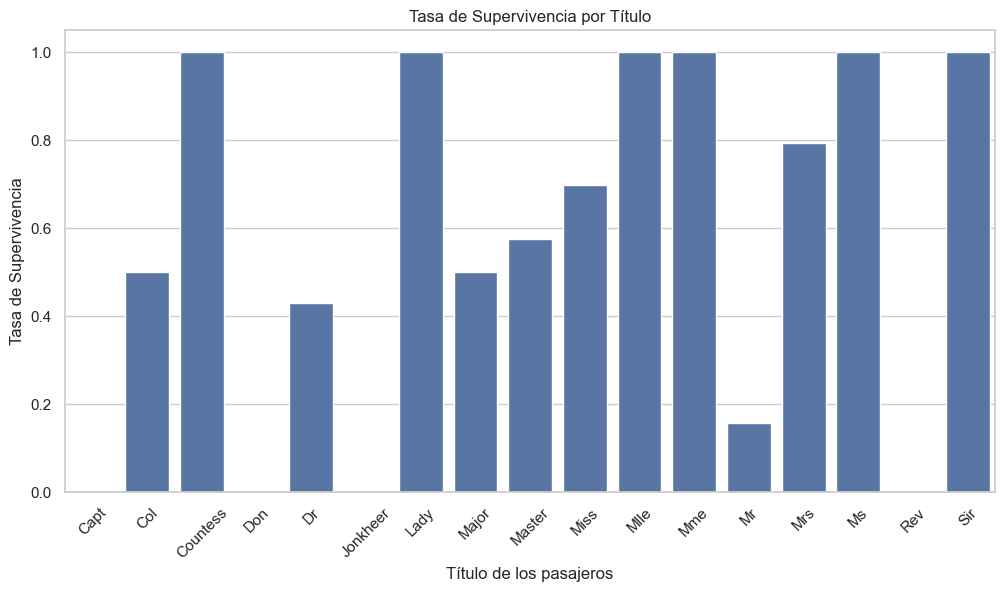

In [29]:
plt.figure(figsize=(12, 6))  
sns.set(style="whitegrid")
sns.barplot(x='Title', y='Survival Rate', data=survival_rate_pd)
plt.xlabel('Título de los pasajeros')
plt.ylabel('Tasa de Supervivencia')
plt.title('Tasa de Supervivencia por Título')
plt.xticks(rotation=45)
plt.show()